for all preprocessing needs up until model dev


In [1]:
from pathlib import Path
import sys

# Add repo root and code/ to sys.path
repo_root = Path.cwd().parents[1]
sys.path.insert(0, str(repo_root))
sys.path.insert(0, str(repo_root / "code"))

from utils import helper_functions as hf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.registration import phase_cross_correlation
import os
import importlib
import torch
import torch.nn.functional as F
from scipy import signal
import cv2

---
### load subjects and plot raw fUS activity of their first session over time with label shading (blue = baseline)

Subject: secundo
  data_directory: C:\Users\ESPCI\Documents\GitHub\fUSPredict\sourcedata\secundo
  data_output_dir: C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\secundo
  - MISMATCH: Images=7500, Labels=8109. Shaving to 7500 frames.


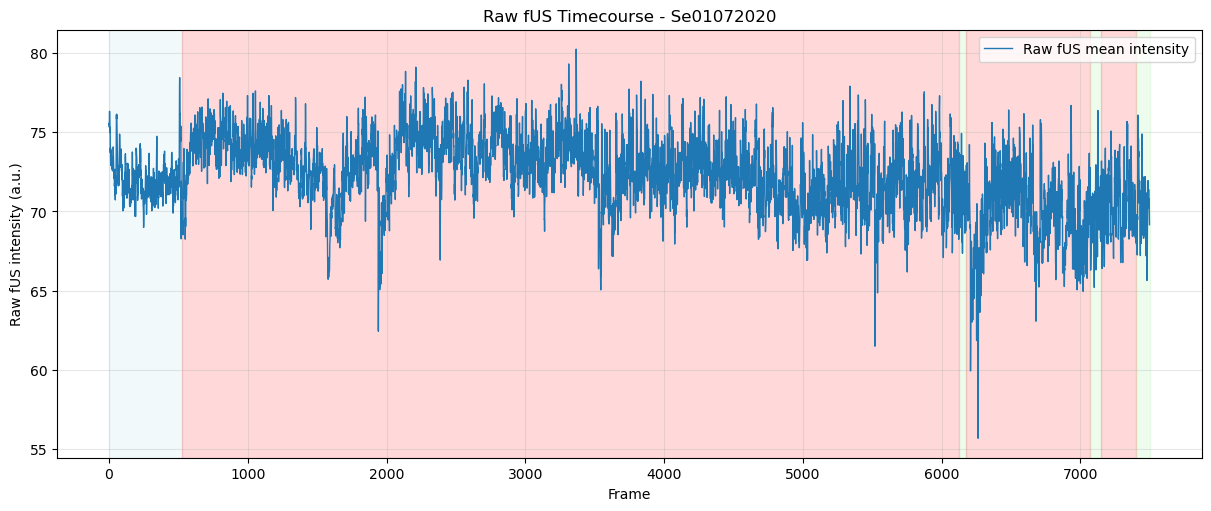

Subject: gus
  data_directory: C:\Users\ESPCI\Documents\GitHub\fUSPredict\sourcedata\gus
  data_output_dir: C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\gus
  - MISMATCH: Images=8000, Labels=9198. Shaving to 8000 frames.


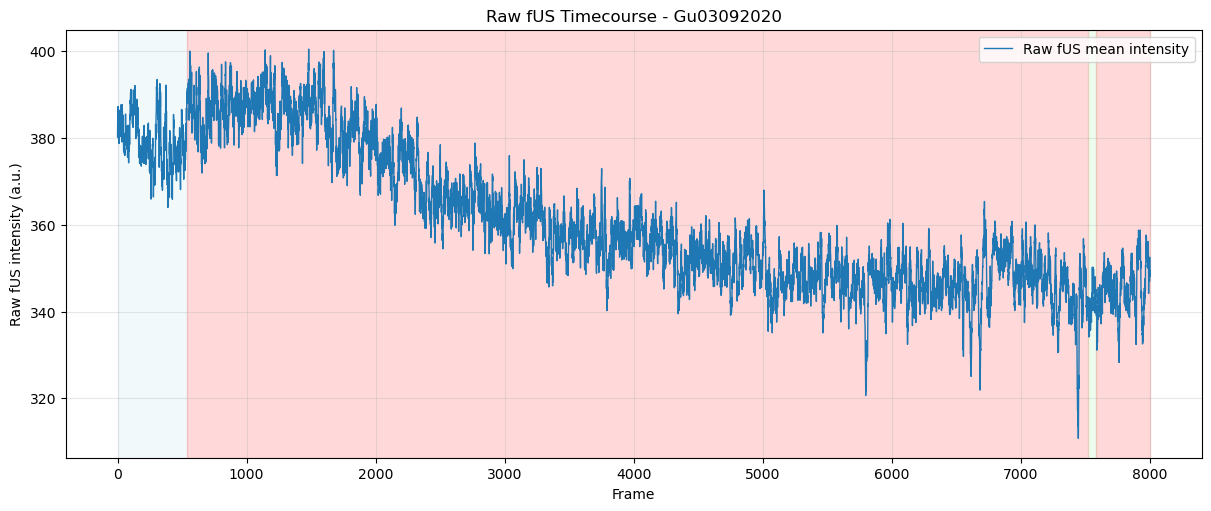

In [2]:
hf = importlib.reload(hf)

subjects = ["secundo", "gus"]

repo_root = Path(r"C:\Users\ESPCI\Documents\GitHub\fUSPredict")
source_root = repo_root / "sourcedata"
deriv_root = repo_root / "derivatives" / "preprocessing"

for subject in subjects:
    data_directory = source_root / subject
    data_output_dir = deriv_root / subject  # subject-specific output folder
    data_output_dir.mkdir(parents=True, exist_ok=True)

    print(f"Subject: {subject}")
    print(f"  data_directory: {data_directory}")
    print(f"  data_output_dir: {data_output_dir}")

    hf.plot_fus_timecourse_with_labels(
        str(data_directory),
        sessions="first"
    )


---
### Extract and Save Baseline Frames

Extract baseline frames (blue shading above, label == -1) from all sessions and save as per-session .npz files.

In [3]:
# Set up output directory for baseline files
for subject in subjects:
    data_directory = source_root / subject
    data_output_dir = deriv_root / subject  # subject-specific output folder
    data_output_dir.mkdir(parents=True, exist_ok=True)
    baseline_output_dir = os.path.join(data_output_dir, "baseline_only")
    print(f"Baseline output directory: {baseline_output_dir}")

    # Process all files for that subject and save baseline files
    baseline_files = hf.process_all_baseline_files(data_directory, baseline_output_dir)

Baseline output directory: C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\secundo\baseline_only
Found 34 fUS files to process

⏭️  Skipping Se01072020 (already exists)
⏭️  Skipping Se01092020 (already exists)
⏭️  Skipping Se01102020 (already exists)
⏭️  Skipping Se01122020 (already exists)
⏭️  Skipping Se02122020 (already exists)
⏭️  Skipping Se03022020 (already exists)
⏭️  Skipping Se03092020 (already exists)
⏭️  Skipping Se04022020 (already exists)
⏭️  Skipping Se04032020 (already exists)
⏭️  Skipping Se04062021 (already exists)
⏭️  Skipping Se04082020 (already exists)
⏭️  Skipping Se04092020 (already exists)
⏭️  Skipping Se05022020 (already exists)
⏭️  Skipping Se05082020 (already exists)
⏭️  Skipping Se06012020 (already exists)
⏭️  Skipping Se22092020 (already exists)
⏭️  Skipping Se22102019 (already exists)
⏭️  Skipping Se22112019 (already exists)
⏭️  Skipping Se23072020 (already exists)
⏭️  Skipping Se24022020 (already exists)
⏭️  Skipping Se24062020 (alread

---
### Load Baseline Data

Load baseline sessions for model training.

In [4]:
for subject in subjects:
    data_directory = source_root / subject
    data_output_dir = deriv_root / subject  # subject-specific output folder
    data_output_dir.mkdir(parents=True, exist_ok=True)
    baseline_output_dir = os.path.join(data_output_dir, "baseline_only")
    # Load all baseline sessions
    baseline_sessions = hf.load_all_baseline(baseline_output_dir)

    # Print summary
    if len(baseline_sessions) > 0:
        print(f"\nBaseline Data Summary:")
        print(f"  Total sessions: {len(baseline_sessions)}")
        total_frames = sum(s['frames'].shape[0] for s in baseline_sessions)
        print(f"  Total baseline frames: {total_frames:,}")
        
        spatial_shapes = [s['frames'].shape[1:] for s in baseline_sessions]
        unique_shapes = set(spatial_shapes)
        print(f"  Spatial dimensions: {unique_shapes}")
        
        # Show frame count distribution
        frame_counts = [s['frames'].shape[0] for s in baseline_sessions]
        print(f"  Frames per session: min={min(frame_counts)}, max={max(frame_counts)}, "
            f"mean={np.mean(frame_counts):.0f}, std={np.std(frame_counts):.0f}")
        
        # first session
        if len(baseline_sessions) > 0:
            first_session = baseline_sessions[0]
            print(f"\n  First session ({first_session['session_id']}):")
            print(f"    Frames: {first_session['frames'].shape[0]}")
            print(f"    Shape: {first_session['frames'].shape}")
            print(f"    Dtype: {first_session['frames'].dtype}")
            print(f"    Value range: [{first_session['frames'].min():.2f}, {first_session['frames'].max():.2f}]")

✅ Loaded 34 baseline sessions

Baseline Data Summary:
  Total sessions: 34
  Total baseline frames: 14,043
  Spatial dimensions: {(128, 107), (128, 91), (128, 132), (128, 122), (128, 112), (128, 96), (128, 101)}
  Frames per session: min=1, max=906, mean=413, std=202

  First session (Se01072020):
    Frames: 526
    Shape: (526, 128, 101)
    Dtype: float32
    Value range: [9.31, 3374.84]
✅ Loaded 13 baseline sessions

Baseline Data Summary:
  Total sessions: 13
  Total baseline frames: 5,838
  Spatial dimensions: {(128, 81), (128, 132), (128, 122), (128, 112), (128, 96), (128, 101)}
  Frames per session: min=258, max=549, mean=449, std=123

  First session (Gu03092020):
    Frames: 539
    Shape: (539, 128, 112)
    Dtype: float32
    Value range: [9.11, 16195.08]


✅ Loaded 34 baseline sessions


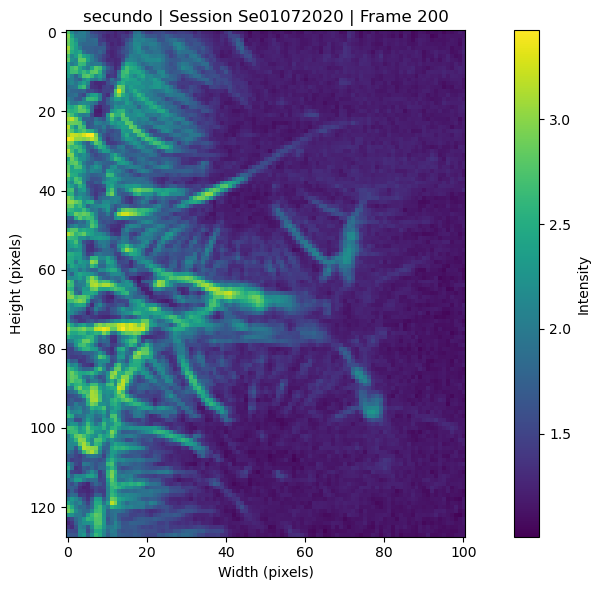

✅ Loaded 13 baseline sessions


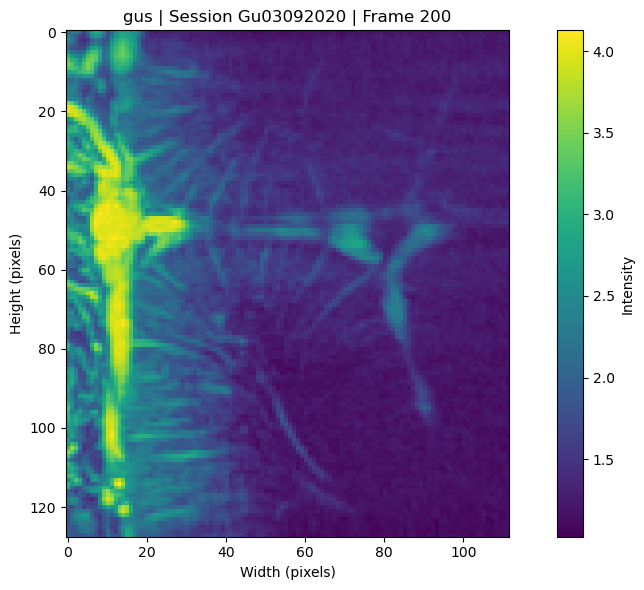

In [5]:
for subject in subjects:
    data_directory = source_root / subject
    data_output_dir = deriv_root / subject
    data_output_dir.mkdir(parents=True, exist_ok=True)
    baseline_output_dir = data_output_dir / "baseline_only"

    baseline_sessions = hf.load_all_baseline(str(baseline_output_dir))

    if len(baseline_sessions) == 0:
        print(f"No baseline sessions for {subject}")
        continue

    sample_session = baseline_sessions[0]
    frame_idx = min(200, len(sample_session["frames"]) - 1)
    sample_frame = sample_session["frames"][frame_idx]

    plt.figure(figsize=(10, 6))
    plt.imshow(np.log10(sample_frame.astype(np.float32) + 1e-8), cmap="viridis")
    plt.colorbar(label="Intensity")
    plt.title(f"{subject} | Session {sample_session['session_id']} | Frame {frame_idx}")
    plt.xlabel("Width (pixels)")
    plt.ylabel("Height (pixels)")
    plt.tight_layout()
    plt.show()


---

make a movie


In [6]:
# export sample baseline video
for subject in subjects:
    data_directory = source_root / subject
    data_output_dir = deriv_root / subject
    data_output_dir.mkdir(parents=True, exist_ok=True)
    baseline_output_dir = data_output_dir / "baseline_only"

    baseline_sessions = hf.load_all_baseline(str(baseline_output_dir))

    if len(baseline_sessions) == 0:
        print(f"No baseline sessions for {subject}")
        continue

    sample_session = baseline_sessions[0]
    sample_frames = sample_session["frames"]

    # Normalize frames to [0, 255] for video export
    normalized_frames = (sample_frames - sample_frames.min()) / (sample_frames.max() - sample_frames.min())
    normalized_frames = (normalized_frames * 255).astype(np.uint8)

    # Save as video using OpenCV
    video_path = data_output_dir / f"{subject}_baseline_sample.avi"
    height, width = normalized_frames.shape[1], normalized_frames.shape[2]
    out = cv2.VideoWriter(str(video_path), cv2.VideoWriter_fourcc(*'XVID'), 10, (width, height), isColor=False)

    for frame in normalized_frames:
        out.write(frame)

    out.release()
    print(f"Saved baseline video for {subject} at: {video_path}")

✅ Loaded 34 baseline sessions
Saved baseline video for secundo at: C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\secundo\secundo_baseline_sample.avi
✅ Loaded 13 baseline sessions
Saved baseline video for gus at: C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\gus\gus_baseline_sample.avi


normalize, then make a movie

In [7]:
# normalize per frame, then make a movie

for subject in subjects:
    data_directory = source_root / subject
    data_output_dir = deriv_root / subject
    data_output_dir.mkdir(parents=True, exist_ok=True)
    baseline_output_dir = data_output_dir / "baseline_only"

    baseline_sessions = hf.load_all_baseline(str(baseline_output_dir))

    if len(baseline_sessions) == 0:
        print(f"No baseline sessions for {subject}")
        continue

    sample_session = baseline_sessions[0]
    sample_frames = sample_session["frames"]

    # Normalize frames to [0, 255] for video export
    normalized_frames = (sample_frames - sample_frames.min()) / (sample_frames.max() - sample_frames.min())
    normalized_frames = (normalized_frames * 255).astype(np.uint8)
    # Save as video using OpenCV
    video_path = data_output_dir / f"{subject}_baseline_sample_normalized.avi"
    height, width = normalized_frames.shape[1], normalized_frames.shape[2]
    out = cv2.VideoWriter(str(video_path), cv2.VideoWriter_fourcc(*'XVID'), 10, (width, height), isColor=False)
    for frame in normalized_frames:
        out.write(frame)
    out.release()
    print(f"Saved normalized baseline video for {subject} at: {video_path}")

✅ Loaded 34 baseline sessions
Saved normalized baseline video for secundo at: C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\secundo\secundo_baseline_sample_normalized.avi
✅ Loaded 13 baseline sessions
Saved normalized baseline video for gus at: C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\gus\gus_baseline_sample_normalized.avi


---
# compute autocorrelation per pixel and comput median time to acf = 0.5 or e-fold decay, and distribution across frame (heatmap)


✅ Loaded 34 baseline sessions
secundo | Median time to ACF < 0.5: 1.00 frames


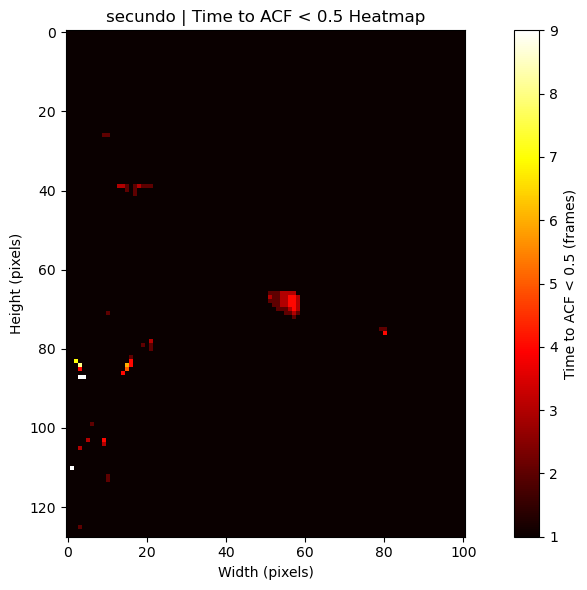

✅ Loaded 13 baseline sessions
gus | Median time to ACF < 0.5: 1.00 frames


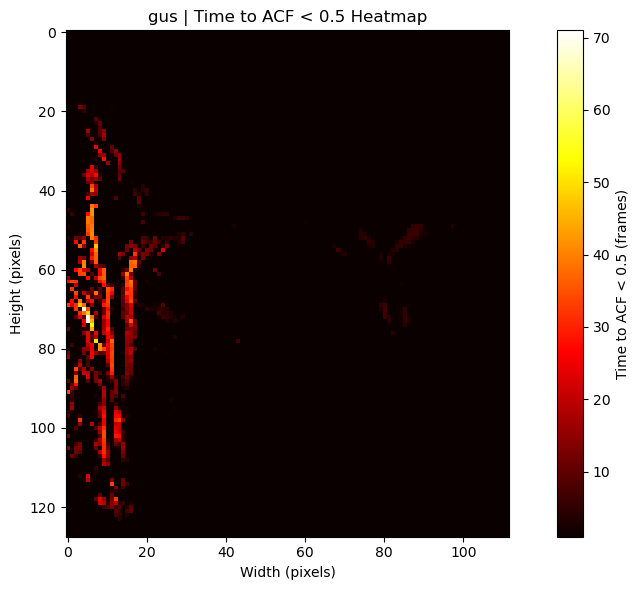

In [ ]:
# compute autocorrelation per pixel and compute median time to acf = 0.5 or e-fold decay, and distribution across frame (heatmap)

for subject in subjects:
    data_directory = source_root / subject
    data_output_dir = deriv_root / subject
    data_output_dir.mkdir(parents=True, exist_ok=True)
    baseline_output_dir = data_output_dir / "baseline_only"

    baseline_sessions = hf.load_all_baseline(str(baseline_output_dir))

    if len(baseline_sessions) == 0:
        print(f"No baseline sessions for {subject}")
        continue

    sample_session = baseline_sessions[0]
    sample_frames = sample_session["frames"]

    # Compute autocorrelation per pixel
    acf_values = np.zeros(sample_frames.shape[1:])  # [H, W]
    for i in range(sample_frames.shape[1]):
        for j in range(sample_frames.shape[2]):
            pixel_timecourse = sample_frames[:, i, j]
            if np.std(pixel_timecourse) == 0:
                acf_values[i, j] = 0
                continue
            acf = signal.correlate(pixel_timecourse - np.mean(pixel_timecourse), pixel_timecourse - np.mean(pixel_timecourse), mode='full')
            acf /= acf[acf.size // 2]  # Normalize
            acf_pos = acf[acf.size // 2:]  # non-negative lags
            below = np.where(acf_pos[1:] < 0.5)[0]  # skip lag 0
            acf_values[i, j] = (below[0] + 1) if len(below) else (len(acf_pos) - 1)
            #compute median time to ACF < 0.5


    # Plot heatmap of time to ACF < 0.5
    plt.figure(figsize=(10, 6))
    plt.imshow(acf_values, cmap="hot")
    plt.colorbar(label="Time to ACF < 0.5 (frames)")
    plt.title(f"{subject} | Time to ACF < 0.5 Heatmap")
    plt.xlabel("Width (pixels)")
    plt.ylabel("Height (pixels)")
    plt.tight_layout()
    plt.show()